<a href="https://colab.research.google.com/github/Danny2173/RAGproject/blob/main/8_Report_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports and Installs

In [1]:
%pip install matplotlib numpy

import pickle
import matplotlib.pyplot as plt
import numpy as np
import json
import re
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Open Domain QA RAG Paper Analysis

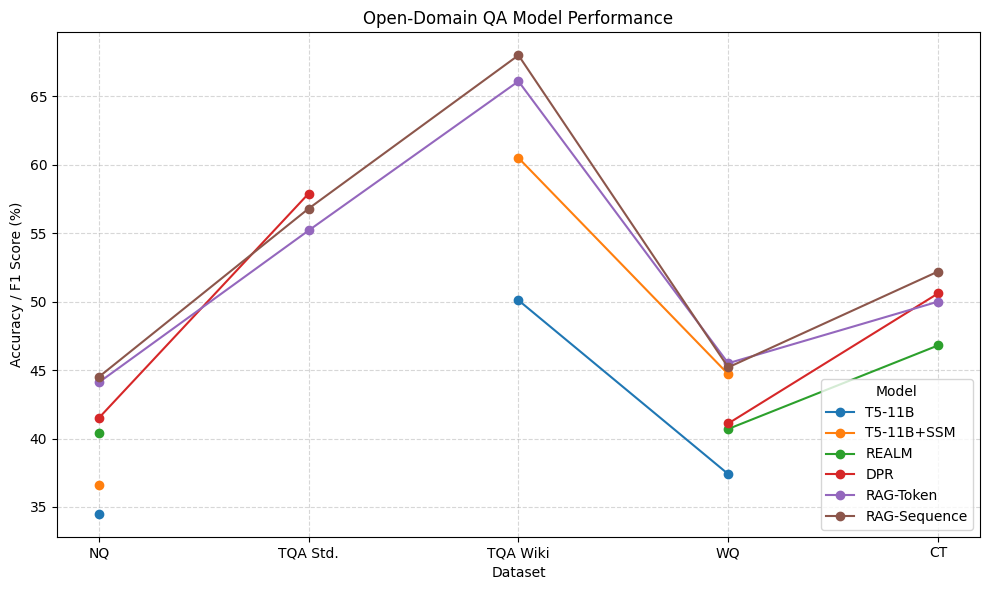

In [2]:
# Datasets
datasets = ["NQ", "TQA Std.", "TQA Wiki", "WQ", "CT"]

# Model scores
model_scores = {
    "T5-11B":         [34.5, None, 50.1, 37.4, None],
    "T5-11B+SSM":     [36.6, None, 60.5, 44.7, None],
    "REALM":          [40.4, None, None, 40.7, 46.8],
    "DPR":            [41.5, 57.9, None, 41.1, 50.6],
    "RAG-Token":      [44.1, 55.2, 66.1, 45.5, 50.0],
    "RAG-Sequence":   [44.5, 56.8, 68.0, 45.2, 52.2],
}


plt.figure(figsize=(10, 6))

for model, scores in model_scores.items():
    y_values = [s if s is not None else np.nan for s in scores]
    plt.plot(datasets, y_values, marker='o', label=model)

plt.title("Open-Domain QA Model Performance")
plt.xlabel("Dataset")
plt.ylabel("Accuracy / F1 Score (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Model", loc='lower right')
plt.tight_layout()
plt.show()


## Generation and Classification RAG Paper Analysis

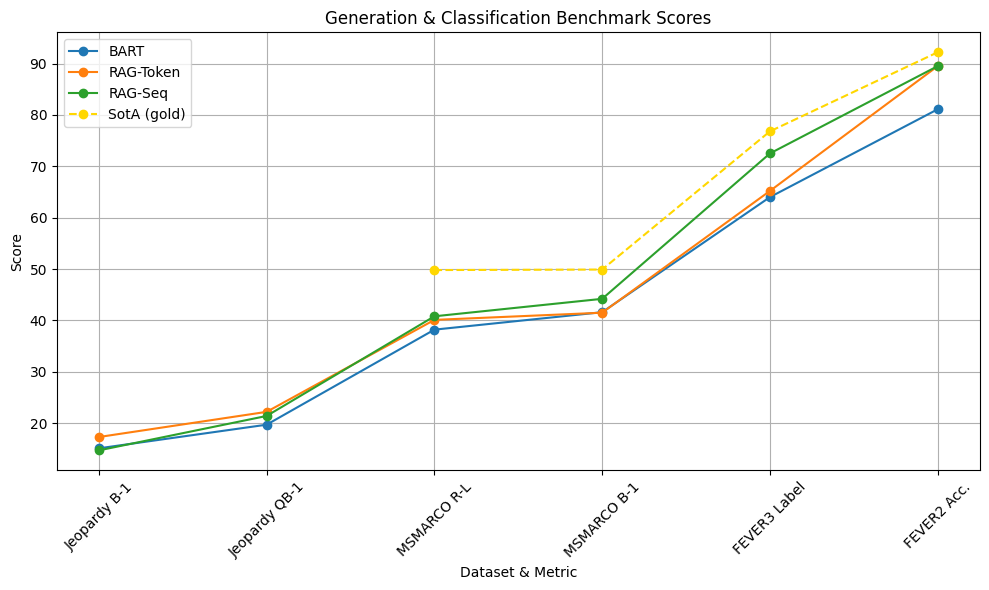

In [3]:
# Datasets
datasets = ["Jeopardy B-1", "Jeopardy QB-1", "MSMARCO R-L", "MSMARCO B-1", "FEVER3 Label", "FEVER2 Acc."]

# Model scores
bart_scores =      [15.1, 19.7, 38.2, 41.6, 64.0, 81.1]
rag_tok_scores =   [17.3, 22.2, 40.1, 41.5, 65.2, 89.5]
rag_seq_scores =   [14.7, 21.4, 40.8, 44.2, 72.5, 89.5]

# Gold scores
sota_scores =      [None, None, 49.8, 49.9, 76.8, 92.2]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(datasets, bart_scores, marker='o', label='BART')
plt.plot(datasets, rag_tok_scores, marker='o', label='RAG-Token')
plt.plot(datasets, rag_seq_scores, marker='o', label='RAG-Seq')
plt.plot(datasets, sota_scores, marker='o', linestyle='--', color='gold', label='SotA (gold)')

plt.title("Generation & Classification Benchmark Scores")
plt.xlabel("Dataset & Metric")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


## Social Media News Usage

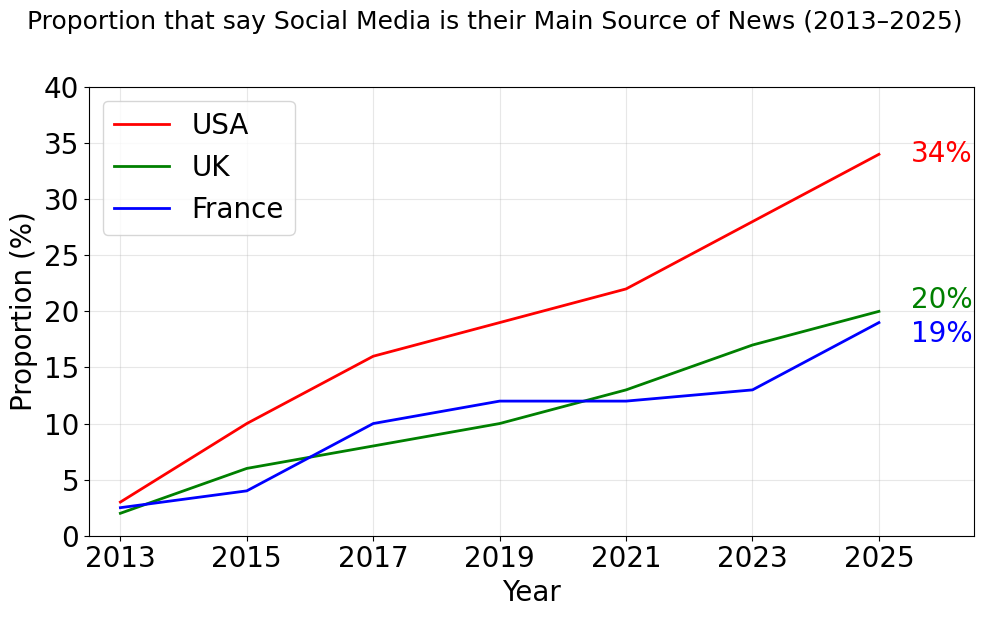

In [4]:
# Years
years = [2013, 2015, 2017, 2019, 2021, 2023, 2025]

# data (%)
usa =     [3, 10, 16, 19, 22, 28, 34]
uk =      [2, 6, 8, 10, 13, 17, 20]
france =  [2.5, 4, 10, 12, 12, 13, 19]

# Plotting
plt.figure(figsize=(10,6))
plt.plot(years, usa, label="USA", color="red", linewidth=2)
plt.plot(years, uk, label="UK", color="green", linewidth=2)
plt.plot(years, france, label="France", color="blue", linewidth=2)


plt.text(2025+0.5, usa[-1], f"{usa[-1]}%", color="red", va='center', fontsize=20)
plt.text(2025+0.5, uk[-1]+1, f"{uk[-1]}%", color="green", va='center', fontsize=20)
plt.text(2025+0.5, france[-1]-1, f"{france[-1]}%", color="blue", va='center', fontsize=20)


# Formatting
plt.suptitle("Proportion that say Social Media is their Main Source of News (2013–2025)", fontsize=18, y=1.02)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Proportion (%)", fontsize=20)
plt.xticks(years, fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0, 40)
plt.xlim(2012.5, 2026.5)
plt.legend(fontsize=20)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Load Corpus

In [5]:
# Load corpus
with open("/content/drive/MyDrive/corpus.pkl", "rb") as f:
    corpus = pickle.load(f)

In [ ]:
for i in range(36, 42):
    print(corpus[i]["text"])
    print("--"*50)

## Counting Prefixes

In [7]:
# Load JSON data
load_path = "/content/drive/MyDrive/expanded_dataset.json"
with open(load_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract first words
first_words = []
for item in data:
    if 'question' in item:
        first_word = item['question'].strip().split()[0].lower()
        first_words.append(first_word)

# Count frequencies
word_counter = Counter(first_words)

# Most common
for word, freq in word_counter.most_common(20):
    print(f"{word}: {freq}")


what: 5080
how: 27
when: 5
who: 3
if: 2
can: 1
ursodeoxycholic: 1
where: 1
are: 1


## Fine-tuning dataset response sentiment

In [9]:
# Load JSON data
load_path = "/content/drive/MyDrive/expanded_dataset.json"
with open(load_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Negative words
refuting_phrases = [
    r"\bno\b", r"\bdoes not\b", r"\bdo not\b", r"\bis not\b", r"\bare not\b",
    r"\bcannot\b", r"\bcan't\b", r"\bshould not\b", r"\bwon't\b",
    r"\bit doesn't\b", r"\bit does not\b"
]
# Positive
agreeing_phrases = [
    r"\byes\b", r"\bdoes\b", r"\bdo\b", r"\bis\b", r"\bare\b", r"\bcan\b",
    r"\bshould\b", r"\bwill\b", r"\bit does\b", r"\bit is\b",
    r"\bthere is\b", r"\bthere are\b"
]

# Counters
refuting_count = 0
agreeing_count = 0
neutral_count = 0

# Sample collections
refuting_samples = []
agreeing_samples = []
neutral_samples = []

# Iterate through data
for item in data:
    answer = item.get('answer', '').strip().lower()

    refuted = any(re.search(pattern, answer) for pattern in refuting_phrases)
    agreed = any(re.search(pattern, answer) for pattern in agreeing_phrases)

    if refuted and not agreed:
        refuting_count += 1
        refuting_samples.append(item)
    elif agreed and not refuted:
        agreeing_count += 1
        agreeing_samples.append(item)
    elif refuted and agreed:
        neutral_count += 1
        neutral_samples.append(item)
    else:
        neutral_count += 1
        neutral_samples.append(item)

# Total
total_answers = len(data)

# Summary Output
print(f"Total answers: {total_answers}")
print(f"Refuting answers: {refuting_count} ({refuting_count / total_answers * 100:.2f}%)")
print(f"Agreeing answers: {agreeing_count} ({agreeing_count / total_answers * 100:.2f}%)")
print(f"Neutral/Other answers: {neutral_count} ({neutral_count / total_answers * 100:.2f}%)")

print("\nRefuting Example")
for sample in refuting_samples[:3]:
    print(f"Q: {sample.get('question', '')}\nA: {sample.get('answer', '')}\n")

print("\nAgreeing Example")
for sample in agreeing_samples[:3]:
    print(f"Q: {sample.get('question', '')}\nA: {sample.get('answer', '')}\n")


Total answers: 5121
Refuting answers: 8 (0.16%)
Agreeing answers: 4536 (88.58%)
Neutral/Other answers: 577 (11.27%)

Refuting Example
Q: What are the symptoms of bile duct cancer?
A: The symptoms of bile duct cancer include the whites of your eyes turning yellow or your skin turning yellow (jaundice), itchy skin, darker urine and paler stools than usual, loss of appetite or unintentional weight loss, feeling generally unwell, feeling tired or having no energy, and experiencing a high temperature or feeling hot or shivery.

Q: What are the symptoms of breast cancer that spreads to other parts of the body?
A: The symptoms of breast cancer that spreads to other parts of the body include feeling tired or having no energy, experiencing loss of appetite or losing weight without trying to, feeling unwell with no clear cause, feeling or being sick, and having difficulty sleeping.

Q: What can cause a baby with a cleft lip and palate to be unable to breastfeed or feed from a normal bottle?
A: A